In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('../data/cleaned_data_ML.csv', index_col=0)

In [3]:
X = data.drop(columns='Heart_Disease')
y = data['Heart_Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)

In [4]:
y_train.value_counts()

0.0    214613
1.0     13290
Name: Heart_Disease, dtype: int64

Lets resample the training data so theres no class imbalance

In [5]:
from sklearn.utils import resample
# Separate majority and minority classes
training = pd.concat([X_train, y_train], axis=1)

df_majority = training[training.Heart_Disease==0]
df_minority = training[training.Heart_Disease==1]
 
# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=214613,     # to match training majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Heart_Disease'].value_counts()

0.0    214613
1.0    214613
Name: Heart_Disease, dtype: int64

In [6]:
X_train_up = df_upsampled.drop(columns='Heart_Disease')
y_train_up = df_upsampled['Heart_Disease']

In [28]:
model =  Pipeline(
    [
        ('scaler', MinMaxScaler()), 
        ('model', LogisticRegression(max_iter=10000))
    ]
)

In [29]:
model.fit(X_train_up, y_train_up)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', LogisticRegression(max_iter=10000))])

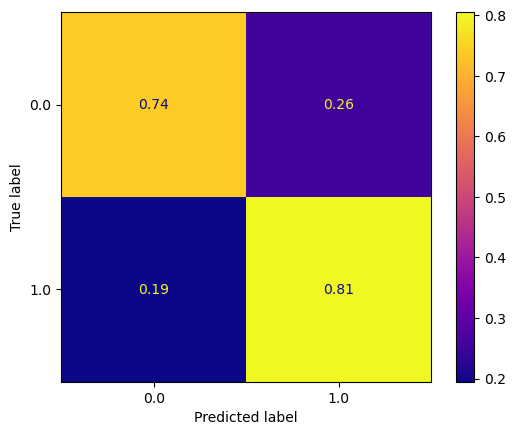

In [30]:
disp = ConfusionMatrixDisplay.from_predictions(y_true = y_test,
                                               y_pred = model.predict(X_test),
                                               normalize='true',
                                               cmap='plasma')

In [31]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85     53626
         1.0       0.16      0.81      0.27      3350

    accuracy                           0.75     56976
   macro avg       0.57      0.77      0.56     56976
weighted avg       0.94      0.75      0.81     56976



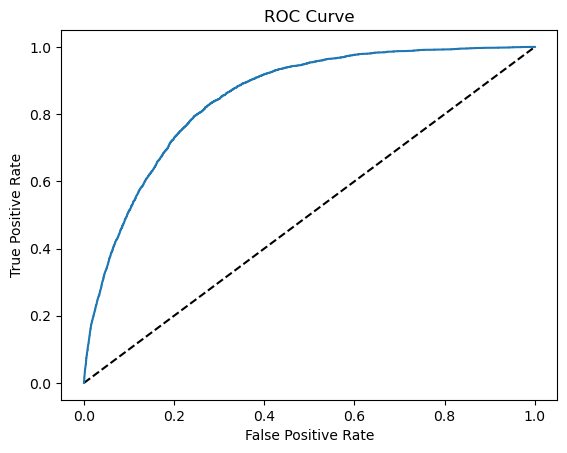

ROC AUC Score:  0.8497231795002537


In [32]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, roc_auc_score

y_predict_probs = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_predict_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('ROC AUC Score: ', roc_auc_score(y_test, y_predict_probs))

SHAP Analysis

In [34]:
feature_names = [X.columns]

In [33]:
import shap

In [35]:
explainer = shap.Explainer(model.named_steps['model'], X_train_up, feature_names=feature_names)
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


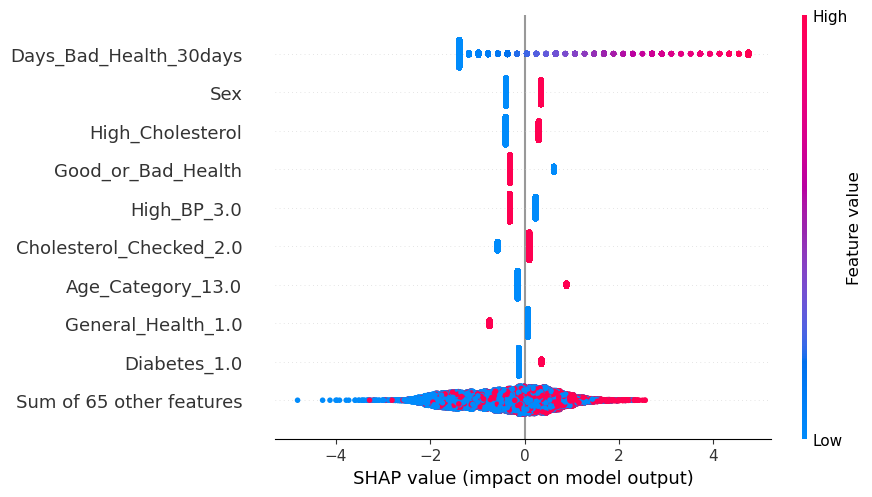

In [36]:
shap.plots.beeswarm(shap_values)
